In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sms-spam-collection-dataset/spam.csv


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score
from nltk.corpus import stopwords
from nltk import word_tokenize, ngrams
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load dataset
df = pd.read_csv("/kaggle/input/sms-spam-collection-dataset/spam.csv", encoding="latin-1")
df = df.rename(columns={"v1":"label", "v2":"text"})[['label','text']]
df['label'] = df['label'].map({'ham':0, 'spam':1})

df.head()


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


## EDA 

In [9]:
stop_words = set(stopwords.words('english'))

def clean_and_tokenize(text):
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    return tokens

df['tokens'] = df['text'].apply(clean_and_tokenize)


In [10]:
from collections import Counter

def get_top_ngrams(tokens_list, n=1, top_k=10):
    all_tokens = [token for tokens in tokens_list for token in tokens]
    n_grams = list(ngrams(all_tokens, n))
    return Counter(n_grams).most_common(top_k)

# Separate spam and ham
spam_tokens = df[df['label']==1]['tokens']
ham_tokens = df[df['label']==0]['tokens']

print("Top 10 Spam Words:", get_top_ngrams(spam_tokens, 1))
print("Top 10 Ham Words:", get_top_ngrams(ham_tokens, 1))

print("Top 10 Spam Bigrams:", get_top_ngrams(spam_tokens, 2))
print("Top 10 Spam Trigrams:", get_top_ngrams(spam_tokens, 3))


Top 10 Spam Words: [(('call',), 346), (('free',), 219), (('txt',), 156), (('ur',), 144), (('u',), 141), (('mobile',), 123), (('text',), 121), (('stop',), 114), (('claim',), 113), (('reply',), 104)]
Top 10 Ham Words: [(('u',), 979), (('gt',), 318), (('lt',), 316), (('get',), 301), (('go',), 248), (('ok',), 245), (('got',), 242), (('ur',), 237), (('know',), 236), (('like',), 231)]
Top 10 Spam Bigrams: [(('please', 'call'), 45), (('po', 'box'), 24), (('guaranteed', 'call'), 23), (('prize', 'guaranteed'), 22), (('call', 'landline'), 22), (('selected', 'receive'), 19), (('send', 'stop'), 19), (('every', 'week'), 19), (('await', 'collection'), 19), (('call', 'claim'), 18)]
Top 10 Spam Trigrams: [(('prize', 'guaranteed', 'call'), 21), (('call', 'land', 'line'), 18), (('private', 'account', 'statement'), 16), (('call', 'identifier', 'code'), 15), (('guaranteed', 'call', 'land'), 15), (('identifier', 'code', 'expires'), 14), (('land', 'line', 'claim'), 14), (('draw', 'shows', 'prize'), 13), (('

## WORDCLOUD

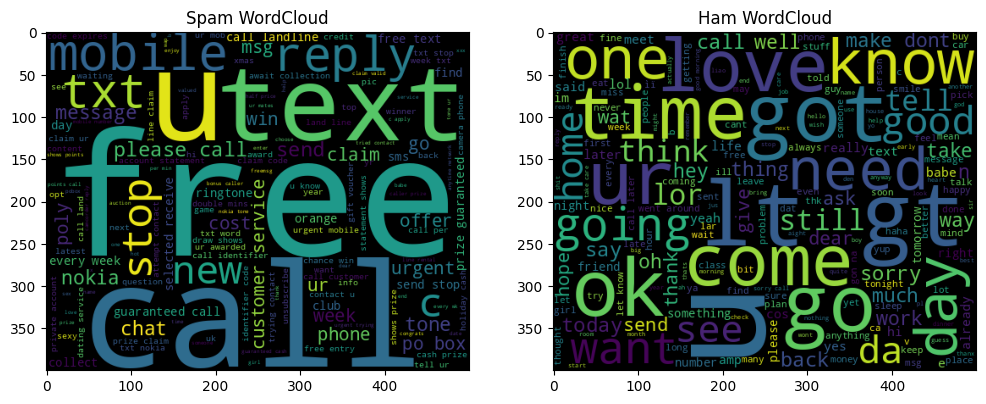

In [11]:
spam_words = ' '.join([' '.join(tokens) for tokens in spam_tokens])
ham_words = ' '.join([' '.join(tokens) for tokens in ham_tokens])

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=500,height=400).generate(spam_words))
plt.title("Spam WordCloud")

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=500,height=400).generate(ham_words))
plt.title("Ham WordCloud")

plt.show()


# BOW & ML

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Bag of Words
cv = CountVectorizer()
X_train_bow = cv.fit_transform(X_train)
X_test_bow = cv.transform(X_test)

model = MultinomialNB()
model.fit(X_train_bow, y_train)
y_pred_bow = model.predict(X_test_bow)

f1_bow = f1_score(y_test, y_pred_bow)
print("F1-score (BoW):", f1_bow)
print(classification_report(y_test, y_pred_bow))


F1-score (BoW): 0.9370629370629371
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.99      0.89      0.94       150

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115



# TF-IDF & MODEL FITTING

In [23]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

model.fit(X_train_tfidf, y_train)
y_pred_tfidf = model.predict(X_test_tfidf)

f1_tfidf = f1_score(y_test, y_pred_tfidf)
print("F1-score (TF-IDF):", f1_tfidf)


F1-score (TF-IDF): 0.8372093023255813


# TEXT PROCESSING +TFIDF +ML

In [24]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # remove URLs
    text = re.sub(r'\S+@\S+', '', text)  # remove emails
    text = re.sub(r'<.*?>', '', text)    # remove HTML tags
    text = re.sub(r'\d+', '', text)      # remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove punctuation
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and len(t)>1]
    return " ".join(tokens)

df['clean_text'] = df['text'].apply(preprocess_text)

X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['label'], test_size=0.2, random_state=42)

tfidf = TfidfVectorizer()
X_train_clean = tfidf.fit_transform(X_train)
X_test_clean = tfidf.transform(X_test)

model.fit(X_train_clean, y_train)
y_pred_clean = model.predict(X_test_clean)

f1_clean = f1_score(y_test, y_pred_clean)
print("F1-score (TF-IDF + Preprocessing):", f1_clean)


F1-score (TF-IDF + Preprocessing): 0.8593155893536121


                    Model  F1-Score
0                     BoW  0.937063
1                  TF-IDF  0.837209
2  TF-IDF + Preprocessing  0.859316


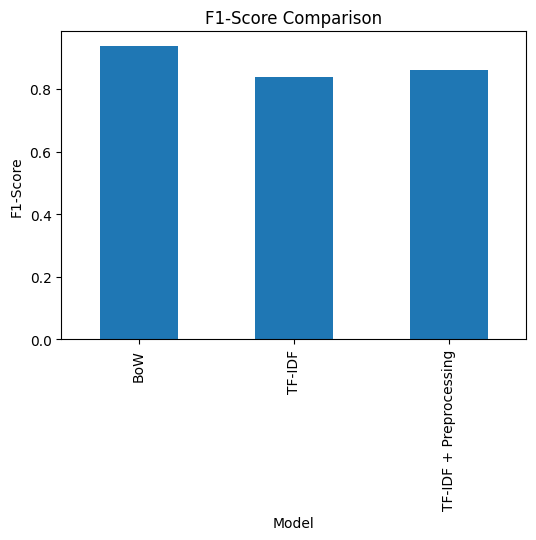

In [25]:
results = pd.DataFrame({
    "Model": ["BoW", "TF-IDF", "TF-IDF + Preprocessing"],
    "F1-Score": [f1_bow, f1_tfidf, f1_clean]
})

print(results)
results.plot(x="Model", y="F1-Score", kind="bar", legend=False, title="F1-Score Comparison", figsize=(6,4))
plt.ylabel("F1-Score")
plt.show()


In [26]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression Model
log_model = LogisticRegression(max_iter=1000)

# 1️⃣ Bag of Words
log_model.fit(X_train_bow, y_train)
y_pred_log_bow = log_model.predict(X_test_bow)
f1_log_bow = f1_score(y_test, y_pred_log_bow)
print("Logistic Regression - F1 (BoW):", f1_log_bow)

# 2️⃣ TF-IDF
log_model.fit(X_train_tfidf, y_train)
y_pred_log_tfidf = log_model.predict(X_test_tfidf)
f1_log_tfidf = f1_score(y_test, y_pred_log_tfidf)
print("Logistic Regression - F1 (TF-IDF):", f1_log_tfidf)

# 3️⃣ TF-IDF + Preprocessing
log_model.fit(X_train_clean, y_train)
y_pred_log_clean = log_model.predict(X_test_clean)
f1_log_clean = f1_score(y_test, y_pred_log_clean)
print("Logistic Regression - F1 (TF-IDF + Preprocessing):", f1_log_clean)


Logistic Regression - F1 (BoW): 0.9130434782608696
Logistic Regression - F1 (TF-IDF): 0.8560606060606061
Logistic Regression - F1 (TF-IDF + Preprocessing): 0.7777777777777777


USING BOTH ML MODELS MULTINOMIALNB AND LOGREG AND WE FOUND OUT BOW with Multinomial Naive Bayes achieved the highest F1-score, showing that raw word frequencies capture spam signals better than TF-IDF in this dataset. Logistic Regression with TF-IDF performed competitively, suggesting it may generalize better for larger or more diverse datasets.